# Decreasing ELBO issue

Possibly caused by comparing and setting prior variances to zero when estimating them with EM.

## Context

In mvSuSiE model with mixture prior, to estimate multivariate prior $b \sim \sum_k \pi_k MVN(0, \sigma_0^2U_k)$ we fix $U_k$ and $\pi_k$ and only estimate the scalar $\sigma_0^2$.

Recent updates to `mvsusieR` package implemented EM updates for $\sigma_0^2$ in both MASH regression and Bayesian multivariate regression (hereafter BMR, essentially MASH with just one component but we have separate, simpler code for it written in R for prototyping purpose). I verified with some tests that for IBSS using MASH mixture with only one matrix the result agree with IBSS using BMR. And BMR, when reduced to just one response, agrees with `susieR::susie` result. The EM estimate for prior variance scalar are identical and ELBO are non-decreasing.


## Problem

However, as I moved on to more simulations I get warnings for decreasing ELBO with the EM estimates. It seems to happen only when there are many effect variables relative to conditions. For example my toy example below has 2 conditions each having 2 effect variables out of 50 variables. The problem is that EM method, as it is currently implemented, estimates $\sigma_0^2$ then at the end of an iteration, compares the update with zero and accept whichever has better likelihood for that single effect model. This resulted in decreasing ELBO.

So far we haven't observed the behavior in SuSiE -- no matter how many effect variables are there, the ELBO is non-decreasing using EM updates. I think both Yuxin and Kaiqian has done some benchmark with SuSiE's EM for prior but don't see an issue.

## Possible cause

If I switch off the comparison between current estimate and zero at the end of each EM update ([comment out this line](https://github.com/stephenslab/mvsusieR/blob/390eb23852fa5ed5c17b5062deb6f3e8494ba76e/R/single_effect_model.R#L22)), then in this example the algorithm takes longer to converge but ELBO is non-decreasing, and is eventually larger than any other approaches (eg, `simple` and `optim` methods). The estimates make more sense compared to the "truth" we know for this simulated data.

I think since EM is not directly maximizing that single effect loglik, we should not compare it with zero at each iteration? Otherwise comparing it and setting $\sigma_0^2 = 0$ will provide a very bad initialization for upcoming iterations.

To see the practical impact: a major difference between EM update and maximizing the single effect loglik directly is that the former is a function of posterior quantities whereas the latter only involves the data, with the prior to be estimated ([here for instance](https://github.com/stephenslab/mvsusieR/blob/390eb23852fa5ed5c17b5062deb6f3e8494ba76e/R/bayesian_simple_regression.R#L73)). As a result, in EM updates if in a previous iteration sets the estimate to zero then it will impact the posterior of the next iteration and the estimate will never come back from zero. This is not the case for when prior is directly estimated as in `optim`.

## Illustration

Here I use BMR not MASH regression to illustrate. **To reproduce you need to run on R 3.6.1+**.

In [1]:
devtools::load_all('~/GIT/software/mvsusieR')
set.seed(1)
dat = mvsusie_sim1(n=50,p=50,r=2,s=2)
L = 10

Loading mvsusieR

Loading required package: mashr

Loading required package: ashr



There are 2 conditions, each having 2 effect variables.

In [2]:
sum(rowSums(dat$b)>0)

[1] 4

### Fit without estimating prior

We use fixed prior here provided by simulated data object; everything looks fine:

In [3]:
dat$V

0.46673960,0.05659291
0.05659291,0.50840182


In [4]:
fit0 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=F)

In [5]:
fit0$elbo

[1] -198.0448 -196.0629 -195.7685 -195.6085 -195.3610 -195.2423 -195.2277
[8] -195.2257 -195.2248

In [6]:
fit0$V

[1] 1 1 1 1 1 1 1 1 1 1

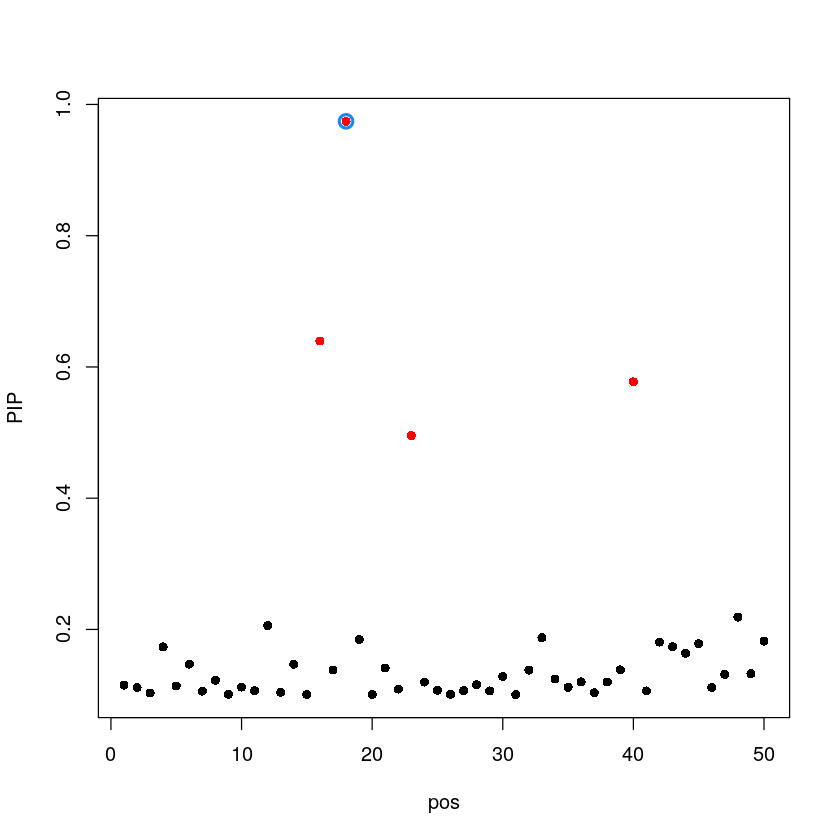

In [7]:
susieR::susie_plot(fit0, 'PIP', b = rowSums(dat$b))

### `simple` method

Using `simple` method, only 1 out of 4 effects was captured.

In [8]:
fit1 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method='simple',
              track_fit=TRUE)

In [9]:
fit1$elbo

[1] -182.7855 -182.7855

In [10]:
fit1$V

[1] 1 0 0 0 0 0 0 0 0 0

Looking at prior estimates in each iteration, 

In [11]:
fit1$prior_history

[[1]]
 [1] 1 0 0 0 0 0 0 0 0 0

[[2]]
 [1] 1 0 0 0 0 0 0 0 0 0

### `EM` method

Now we can see decreasing ELBO: from -183 to -185, compared to previously the ELBO was -182 at convergence,

In [12]:
fit2 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'EM',
              track_fit=TRUE)

Warning message in m$get_objective(dump = TRUE):
“Objective is not non-decreasing”


In [13]:
fit2$elbo

[1] -198.0448 -183.6562 -185.0643

In [14]:
fit2$V

[1] 0 0 0 0 0 0 0 0 0 0

And no effect was captured! It seems in the first iteration both prior are estimated non-zero. But the 2nd iteration they both became zero because zero maximizes the loglik in that iteration. However apparently in the next iteration setting prior to zero decreased the ELBO:

In [16]:
fit2$prior_history

[[1]]
 [1] 0.7722529 0.4376000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[2]]
 [1] 0 0 0 0 0 0 0 0 0 0

[[3]]
 [1] 0 0 0 0 0 0 0 0 0 0

However, when I set `L = 5` it can capture 1 effect,

In [17]:
fit21 = mvsusie(dat$X,dat$y,L=4,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'EM',
              track_fit=T)

Warning message in m$get_objective(dump = TRUE):
“Objective is not non-decreasing”


In [18]:
fit21$elbo

[1] -186.2058 -182.5053 -183.0039

In [19]:
fit21$V

[1] 0.6514982 0.0000000 0.0000000 0.0000000

In [20]:
fit21$prior_history

[[1]]
[1] 0.7722529 0.4376000 0.0000000 0.0000000

[[2]]
[1] 0.5531462 0.0000000 0.0000000 0.0000000

[[3]]
[1] 0.6514982 0.0000000 0.0000000 0.0000000

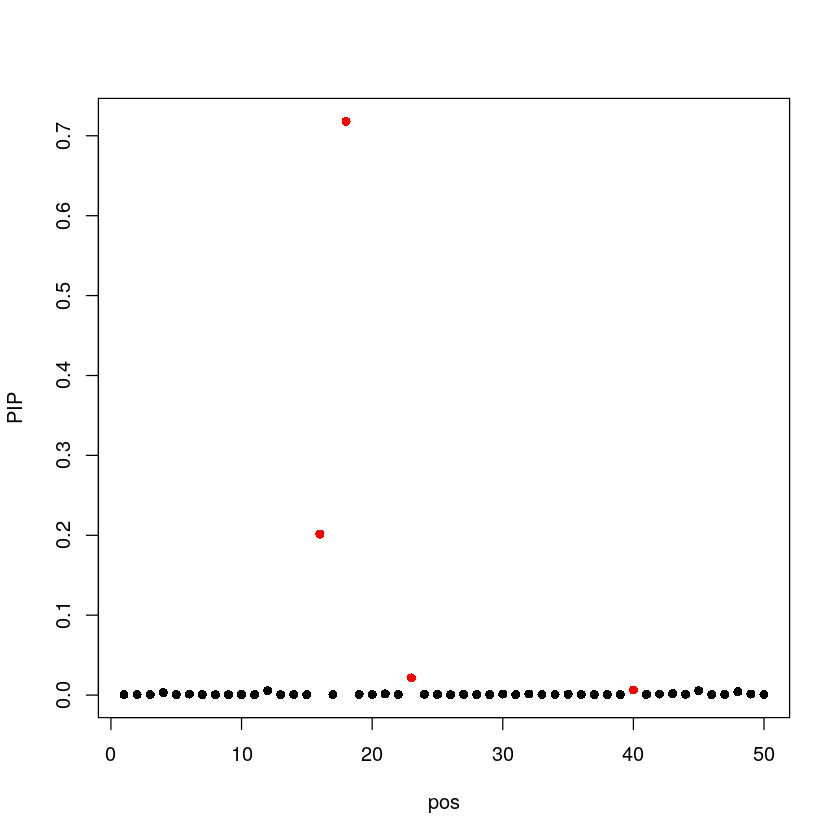

In [21]:
susieR::susie_plot(fit21, 'PIP', b = rowSums(dat$b))

In [22]:
sum(fit21$pip)

[1] 1

### `optim` method

In `optim` method we still have that check at the end of each update comparing current estimate with zero in terms of likelihood. Thus many `V` are set to zero. However, two effects were captured this time,

In [23]:
fit3 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method='optim',
              track_fit=T)

In [24]:
fit3$elbo

[1] -182.6514 -182.4004 -182.2818 -182.2437 -182.1260 -181.7882 -181.6535
 [8] -181.6428 -181.6418 -181.6417

In [25]:
fit3$V

[1] 0.7157811 0.6976432 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

It seems unlike with the EM update, the estimates never hit zero:

In [26]:
fit3$prior_history

[[1]]
 [1] 0.7181046 0.2248014 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[2]]
 [1] 0.6700969 0.3892413 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[3]]
 [1] 0.6982171 0.4645356 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[4]]
 [1] 0.7079827 0.4804744 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[5]]
 [1] 0.7088157 0.5164211 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[6]]
 [1] 0.7208307 0.6297719 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[7]]
 [1] 0.7233757 0.6841689 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[8]]
 [1] 0.7183084 0.6941340 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[9]]
 [1] 0.7164469 0.6968305 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

[[10]]
 [1] 0.7157811 0.6976432 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

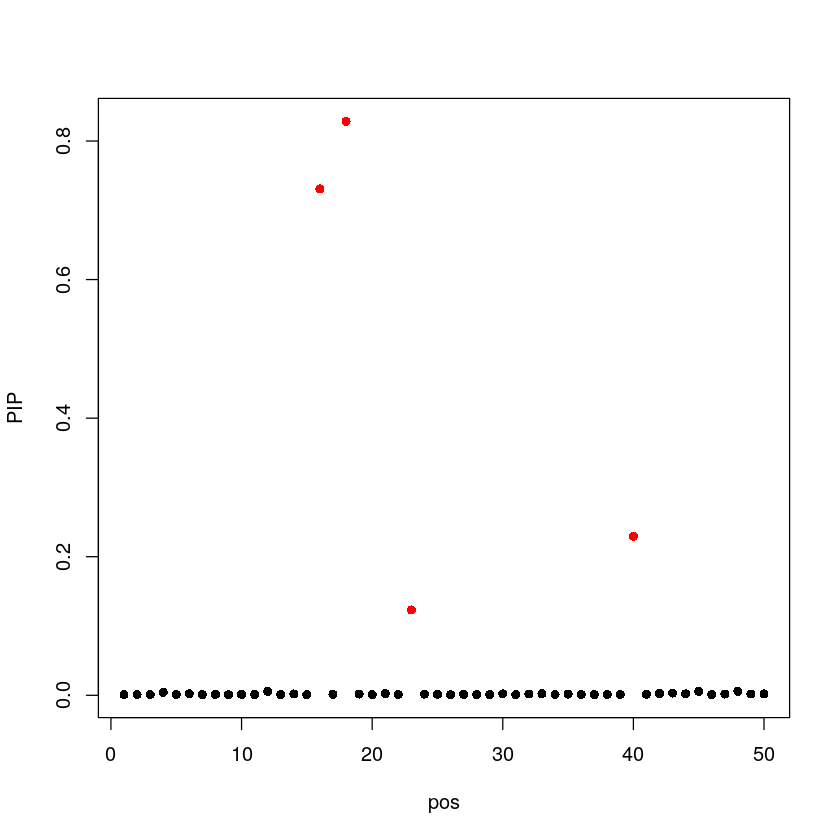

In [27]:
susieR::susie_plot(fit3, 'PIP', b = rowSums(dat$b))

### `EM` update without checking with zero

I commented out [this line](https://github.com/stephenslab/mvsusieR/blob/390eb23852fa5ed5c17b5062deb6f3e8494ba76e/R/single_effect_model.R#L22)) in my code, and run EM with `L=10`:

In [28]:
devtools::load_all('~/GIT/software/mvsusieR')

Loading mvsusieR



In [33]:
fit4 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method='EM', max_iter = 200,
              track_fit=T)

In [34]:
fit4$elbo

[1] -198.0448 -185.8084 -184.1862 -183.7483 -183.5179 -183.3480 -183.2281
  [8] -183.1588 -183.1223 -183.1008 -183.0856 -183.0732 -183.0623 -183.0522
 [15] -183.0423 -183.0320 -183.0208 -183.0076 -182.9911 -182.9687 -182.9357
 [22] -182.8834 -182.7964 -182.6567 -182.4751 -182.3152 -182.2184 -182.1661
 [29] -182.1327 -182.1063 -182.0833 -182.0625 -182.0435 -182.0260 -182.0099
 [36] -181.9950 -181.9812 -181.9684 -181.9565 -181.9453 -181.9349 -181.9252
 [43] -181.9161 -181.9075 -181.8994 -181.8918 -181.8846 -181.8778 -181.8713
 [50] -181.8652 -181.8594 -181.8539 -181.8486 -181.8436 -181.8388 -181.8343
 [57] -181.8299 -181.8257 -181.8218 -181.8179 -181.8143 -181.8107 -181.8073
 [64] -181.8041 -181.8010 -181.7979 -181.7950 -181.7922 -181.7895 -181.7869
 [71] -181.7844 -181.7820 -181.7796 -181.7773 -181.7751 -181.7730 -181.7709
 [78] -181.7689 -181.7670 -181.7651 -181.7632 -181.7615 -181.7597 -181.7581
 [85] -181.7564 -181.7548 -181.7533 -181.7518 -181.7503 -181.7489 -181.7475
 [92] -181.7461 -181.7448 -181.7435 -181.7423 -181.7410 -181.7398 -181.7387
 [99] -181.7375 -181.7364 -181.7353 -181.7343 -181.7332 -181.7322 -181.7312

In [35]:
fit4$niter

[1] 105

It took 105 iterations to converge. The ELBO -181 is comparable to that obtained by `optim`.

The prior estimates are:

In [36]:
fit4$V

[1] 0.714071253 0.688578702 0.003376494 0.003317388 0.003297329 0.003284211
 [7] 0.003274674 0.003267332 0.003261468 0.003256656

In [37]:
fit4$prior_history

[[1]]
 [1] 0.7722529 0.4376000 0.2308166 0.1827126 0.1619665 0.1489050 0.1398383
 [8] 0.1331456 0.1279908 0.1238955

[[2]]
 [1] 0.34878058 0.20483073 0.13264147 0.11399016 0.10513139 0.09881328
 [7] 0.09393160 0.08998921 0.08671232 0.08393161

[[3]]
 [1] 0.31831428 0.13915133 0.09891845 0.08802562 0.08274035 0.07883262
 [7] 0.07572316 0.07314300 0.07094050 0.06902104

[[4]]
 [1] 0.35216700 0.11026090 0.08179428 0.07414434 0.07047771 0.06770798
 [7] 0.06545770 0.06355671 0.06190957 0.06045608

[[5]]
 [1] 0.41348403 0.09470744 0.07125049 0.06517499 0.06235034 0.06021774
 [7] 0.05847674 0.05699518 0.05570058 0.05454817

[[6]]
 [1] 0.49281899 0.08568876 0.06429633 0.05901467 0.05662905 0.05484359
 [7] 0.05339264 0.05216030 0.05108353 0.05012376

[[7]]
 [1] 0.57132121 0.08030508 0.05949092 0.05462855 0.05248792 0.05090088
 [7] 0.04961923 0.04853543 0.04759132 0.04675144

[[8]]
 [1] 0.62983698 0.07703401 0.05596403 0.05133643 0.04934915 0.04788976
 [7] 0.04671878 0.04573319 0.04487762 0.04411848

[[9]]
 [1] 0.66408770 0.07510622 0.05321846 0.04872429 0.04684098 0.04547150
 [7] 0.04438012 0.04346615 0.04267578 0.04197656

[[10]]
 [1] 0.68075126 0.07413801 0.05097615 0.04655458 0.04474519 0.04344254
 [7] 0.04241173 0.04155309 0.04081366 0.04016165

[[11]]
 [1] 0.68750659 0.07393509 0.04907265 0.04468635 0.04293194 0.04168125
 [7] 0.04069855 0.03988447 0.03918646 0.03857313

[[12]]
 [1] 0.68937404 0.07441108 0.04740425 0.04303093 0.04131963 0.04011130
 [7] 0.03916849 0.03839169 0.03772856 0.03714797

[[13]]
 [1] 0.68903240 0.07555274 0.04590137 0.04152918 0.03985393 0.03868191
 [7] 0.03777360 0.03702921 0.03639649 0.03584450

[[14]]
 [1] 0.68779764 0.07740756 0.04451422 0.04013930 0.03849645 0.03735724
 [7] 0.03648008 0.03576491 0.03515960 0.03463337

[[15]]
 [1] 0.68630193 0.08008666 0.04320458 0.03882978 0.03721840 0.03611040
 [7] 0.03526257 0.03457473 0.03399492 0.03349260

[[16]]
 [1] 0.68485877 0.08378247 0.04194079 0.03757522 0.03599662 0.03491983
 [7] 0.03410074 0.03343936 0.03288404 0.03240452

[[17]]
 [1] 0.68364485 0.08880646 0.04069421 0.03635336 0.03481094 0.03376675
 [7] 0.03297689 0.03234198 0.03181088 0.03135373

[[18]]
 [1] 0.68279177 0.09566064 0.03943618 0.03514257 0.03364186 0.03263307
 [7] 0.03187399 0.03126640 0.03075998 0.03032539

[[19]]
 [1] 0.68243919 0.10517187 0.03813479 0.03391935 0.03246830 0.03149924
 [7] 0.03077362 0.03019513 0.02971459 0.02930342

[[20]]
 [1] 0.68277683 0.11874869 0.03675114 0.03265524 0.03126472 0.03034157
 [7] 0.02965345 0.02910690 0.02865434 0.02826819

[[21]]
 [1] 0.68409135 0.13887194 0.03523566 0.03131354 0.02999798 0.02912917
 [7] 0.02848420 0.02797373 0.02755232 0.02719373

[[22]]
 [1] 0.68681962 0.16995641 0.03352968 0.02984898 0.02862645 0.02782267
 [7] 0.02722818 0.02675920 0.02637320 0.02604562

[[23]]
 [1] 0.69155064 0.21930267 0.03159053 0.02822331 0.02711268 0.02638507
 [7] 0.02584868 0.02542683 0.02508065 0.02478768

[[24]]
 [1] 0.69870007 0.29532203 0.02946496 0.02645854 0.02547069 0.02482512
 [7] 0.02435047 0.02397821 0.02367358 0.02341650

[[25]]
 [1] 0.70736718 0.39607933 0.02733787 0.02468404 0.02381308 0.02324466
 [7] 0.02282747 0.02250094 0.02223430 0.02200980

[[26]]
 [1] 0.71457281 0.49713508 0.02539162 0.02304287 0.02227214 0.02176946
 [7] 0.02140089 0.02111280 0.02087789 0.02068041

[[27]]
 [1] 0.71793037 0.57176011 0.02367458 0.02158125 0.02089448 0.02044680
 [7] 0.02011886 0.01986280 0.01965427 0.01947918

[[28]]
 [1] 0.71793502 0.61574355 0.02215994 0.02028289 0.01966730 0.01926629
 [7] 0.01897281 0.01874391 0.01855774 0.01840164

[[29]]
 [1] 0.71637827 0.63876167 0.02081331 0.01912208 0.01856760 0.01820662
 [7] 0.01794269 0.01773708 0.01757007 0.01743022

[[30]]
 [1] 0.71462456 0.65036160 0.01960817 0.01807809 0.01757648 0.01725011
 [7] 0.01701168 0.01682614 0.01667561 0.01654973

[[31]]
 [1] 0.71326538 0.65631763 0.01852429 0.01713479 0.01667920 0.01638288
 [7] 0.01616658 0.01599842 0.01586214 0.01574833

[[32]]
 [1] 0.71239553 0.65958701 0.01754532 0.0162

Here it captures 2 effects, as also reflected below that two effects have large PIP,

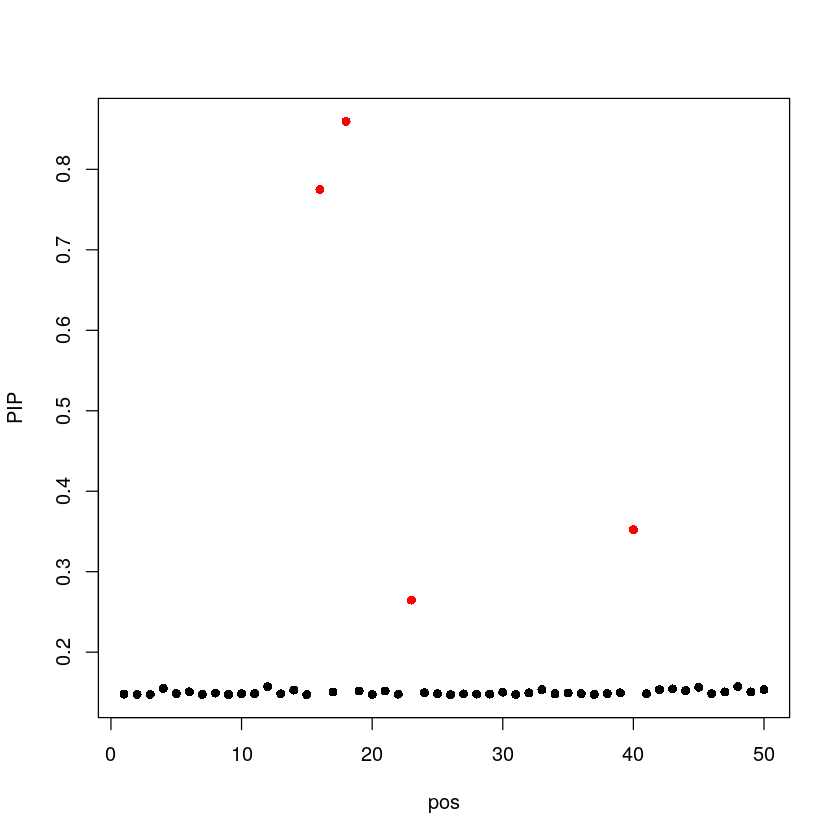

In [58]:
susieR::susie_plot(fit4, 'PIP', b = rowSums(dat$b))

## Final solution

Following from [Matthew's suggestion](https://github.com/stephenslab/mvsusieR/issues/26#issuecomment-612947198), we check with zero and set all posteriors to zero, only after 10 iterations. This is the current default implementation of `EM` method,

In [2]:
fit5 = mvsusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method='EM',
              track_fit=T)

The convergence is now faster,

In [3]:
fit5$niter

[1] 34

In [4]:
fit5$elbo

[1] -198.0448 -185.8084 -184.1862 -183.7483 -183.5179 -183.3480 -183.2281
 [8] -183.1588 -183.1223 -183.1008 -183.0446 -182.8615 -182.8184 -182.7835
[15] -182.7561 -182.7502 -182.7351 -182.7305 -182.7254 -182.7189 -182.7103
[22] -182.6984 -182.6814 -182.6560 -182.6167 -182.5550 -182.4637 -182.3446
[29] -182.1740 -181.8603 -181.6802 -181.6473 -181.6425 -181.6418

This now achieves the same ELBO as `optim` method.

In [5]:
fit5$V

[1] 0.7162723 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.6946221 0.0000000

Here, two effects are captured, with very similar result compared to `optim`; **but they appear in effects 1 and 9!**

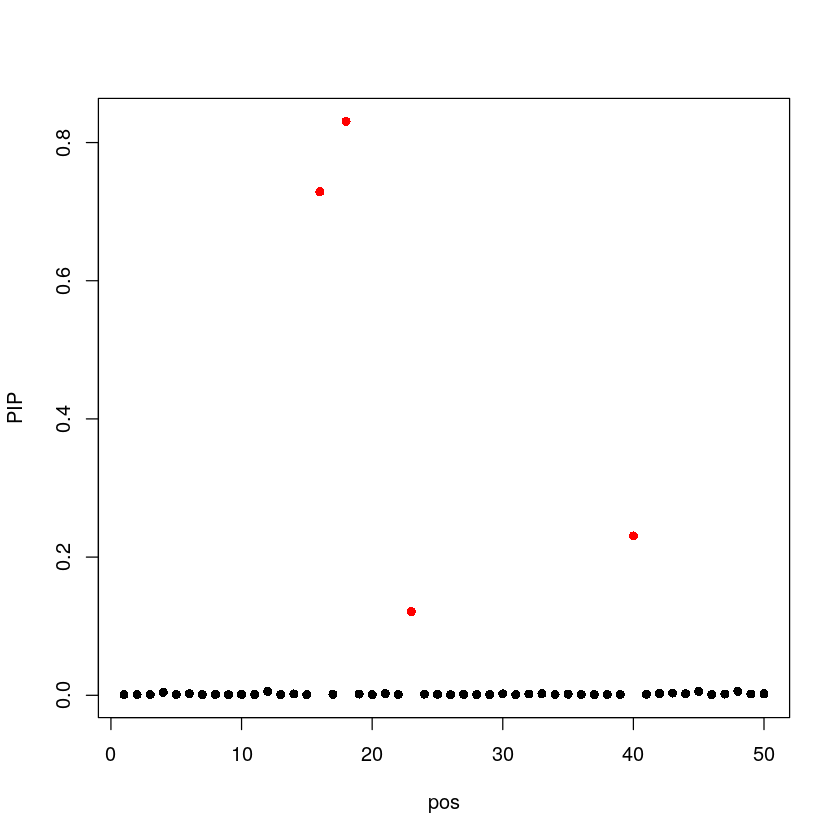

In [6]:
susieR::susie_plot(fit5, 'PIP', b = rowSums(dat$b))